[View in Colaboratory](https://colab.research.google.com/github/aenimaxoxo/Numerical-Linear-Algebra/blob/master/Robust_PCA_Background_Removal.ipynb)

In [3]:
import moviepy.editor as mpe
# from IPython.display import display
from glob import glob

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1605632/45929032 bytes (3.5%)5259264/45929032 bytes (11.5%)8929280/45929032 bytes (19.4%)12763136/45929032 bytes (27.8%)16580608/45929032 bytes (36.1%)20520960/45929032 bytes (44.7%)24403968/45929032 bytes (53.1%)28262400/45929032 bytes (61.5%)32251904/45929032 bytes (70.2%)36159488/45929032 bytes (78.7%)39952384/45929032 bytes (87.0%)43859968/45929032 bytes (95.5%)

In [2]:
!pip install moviepy

    100% |████████████████████████████████| 378kB 9.5MB/s 
    100% |████████████████████████████████| 3.3MB 8.5MB/s 
  Running setup.py bdist_wheel for moviepy ... - \ done
  Stored in directory: /root/.cache/pip/wheels/ad/92/4d/a6c6307d4c2219d002646bd4a5987e31fd5697f6ea7778b2c0
  Running setup.py bdist_wheel for imageio ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built moviepy imageio


In [0]:
import sys, os
import numpy as np
import scipy

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
# MAX_ITERS = 10
TOL = 1.0e-8

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
video = mpe.VideoFileClip("download.mp4")

In [11]:
video.subclip(0, 50).ipython_display(width = 300)

100%|█████████▉| 350/351 [00:00<00:00, 742.14it/s]


In [12]:
video.duration

50.0

**Helper Methods**

In [0]:
def create_data_matrix_from_video(clip, k=5, scale=50):
    return np.vstack([scipy.misc.imresize(rgb2gray(clip.get_frame(i/float(k))).astype(int), 
                      scale).flatten() for i in range(k * int(clip.duration))]).T
  
def rgb2gray(rgb):
  return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

def plt_images(M, A, E, index_array, dims, filename = None): 
  f = plt.figure(figsize = (15, 10))
  r = len(index_array)
  pics = r * 3
  for k, i in enumerate(index_array): 
    for j, mat in enumerate([M, A, E]): 
      sp = f.add_subplot(r, 3, 3*k + j + 1)
      sp.axis('Off')
      pixels = mat[:,i]
      if isinstance(pixels, scipy.sparse.csr_matrix): 
        pixels = pixels.todense() 
      plt.imshow(np.reshape(pixels, dims), cmap = 'gray') 
    return f 
  
def plots(ims, dims, figsize = (15, 20), rows = 1, interp = False, titles = None): 
  if type(ims[0] is np.ndarray): 
    ims = np.array(ims)
  f = plt.figure(figsize = figsize)
  for i in range(len(ims)): 
    sp = f.add_subplot(rows, len(ims)//rows, i+1)
    sp.axis('Off')
    plt.imshow(np.reshape(ims[i], dims), cmap = 'gray')


**Load and View the Data**

An image from 1 moment in time is 60x80 pixels when scaled. We can unroll that pic into a single tall column. So instead of having a 2d pic that is 60 * 80 we have a 1* 4800 column. 

This allows us to stack the images from different times on top of one another to put a video all into 1 matrix


In [15]:
scale = 25 # adjust scale to change resolution of the image 
dims = (int(240 * (scale / 100)), int(320 * (scale / 100)))
M = create_data_matrix_from_video(video, 100, scale)
# M = np.load("high_res_surveillance_matrix.npy")
print(dims, M.shape)

(60, 80) (4800, 5000)


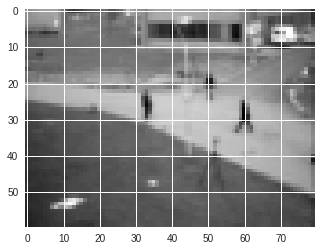

In [16]:
plt.imshow(np.reshape(M[:,140], dims), cmap = 'gray');

In [0]:
np.save("low_res_surveillance_matrix.npy", M)

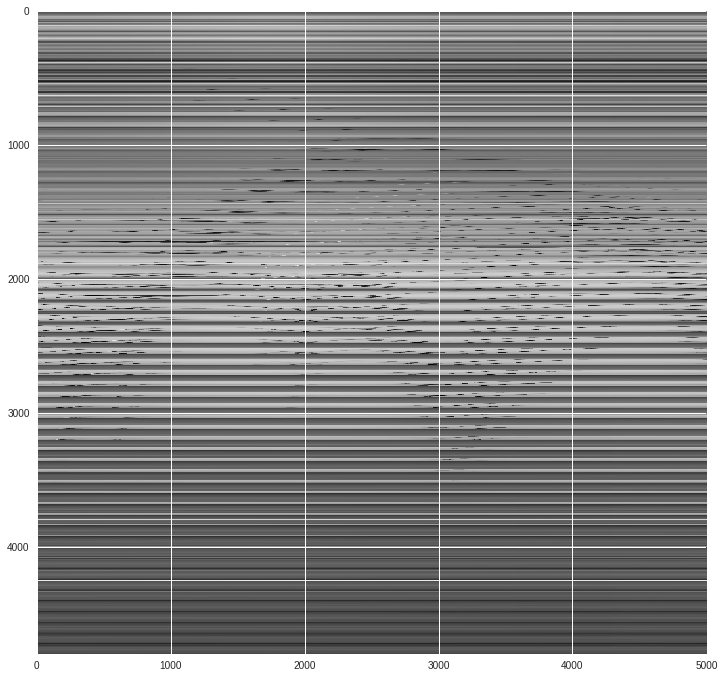

In [18]:
plt.figure(figsize = (12, 12))
plt.imshow(M, cmap = 'gray')

In [0]:
plt.imsave(fname = "image1.jpg", arr = np.reshape(M[:, 140], dims), cmap = 'gray')

**Singular Value Decomposition**

In [0]:
from sklearn import decomposition

In [0]:
u, s, v = decomposition.randomized_svd(M, 2)

In [22]:
u.shape, s.shape, v.shape

((4800, 2), (2,), (2, 5000))

In [23]:
low_rank = u @ np.diag(s) @ v
low_rank.shape

(4800, 5000)

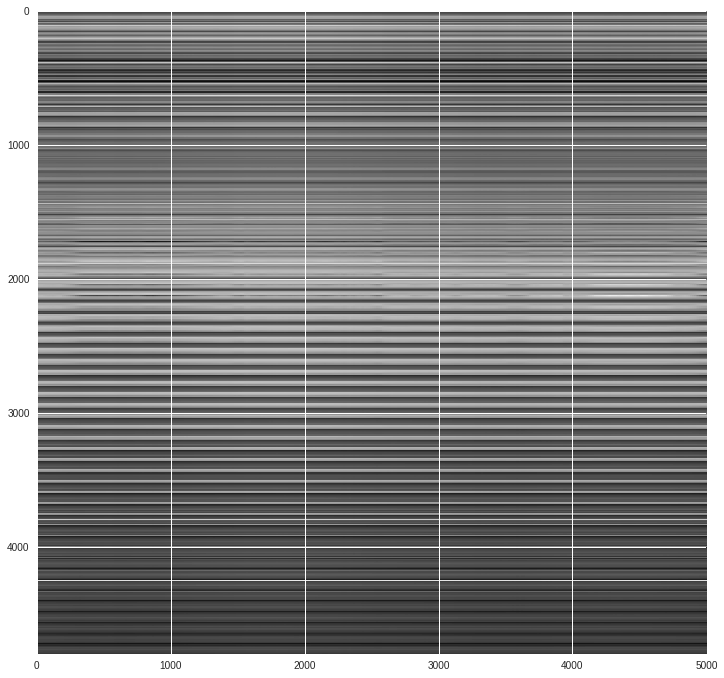

In [24]:
plt.figure(figsize = (12, 12))
plt.imshow(low_rank, cmap = 'gray')

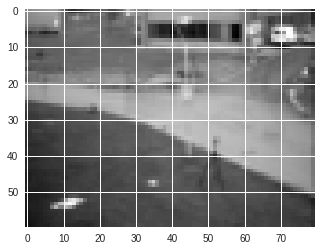

In [25]:
plt.imshow(np.reshape(low_rank[:, 140], dims), cmap = 'gray');

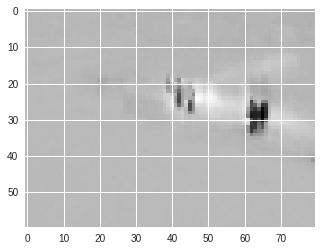

In [26]:
plt.imshow(np.reshape(M[:, 550] - low_rank[:, 550], dims), cmap = 'gray')

**Rank 1 Approximation**

In [0]:
u, s, v = decomposition.randomized_svd(M, 1)

In [28]:
u.shape, s.shape, v.shape

((4800, 1), (1,), (1, 5000))

In [0]:
low_rank = u @ np.diag(s) @ v

In [30]:
low_rank.shape

(4800, 5000)

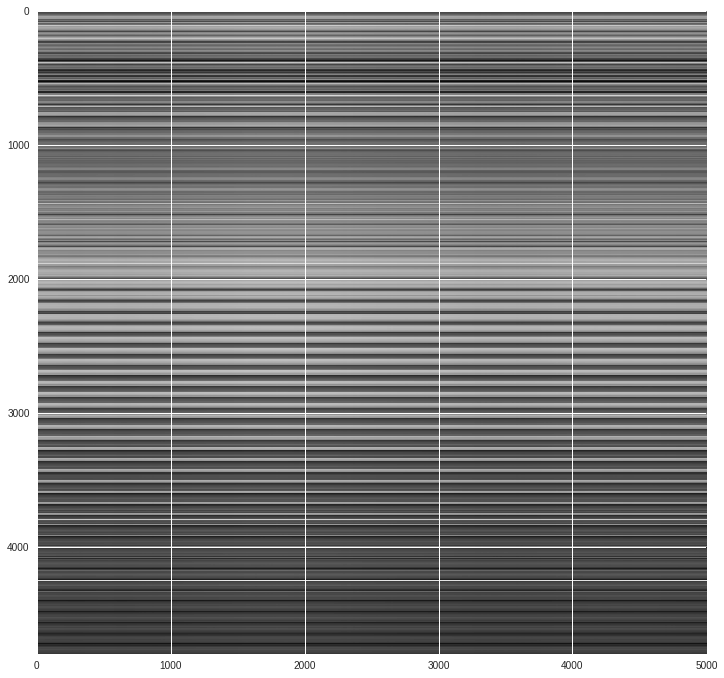

In [40]:
plt.figure(figsize = (12, 12))
plt.imshow(low_rank, cmap = 'gray')

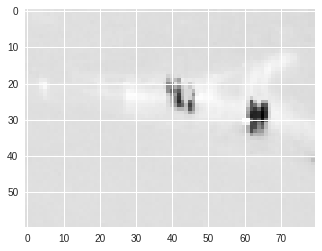

In [41]:
plt.imshow(np.reshape(M[:, 550] - low_rank[:, 550], dims), cmap = 'gray');

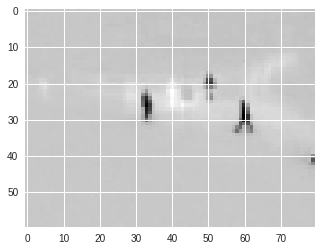

In [42]:
plt.imshow(np.reshape(M[:, 140] - low_rank[:, 140], dims), cmap = 'gray')

**Principal Component Analysis**

We will use Facebook's Fast Randomized PCA library: https://github.com/facebook/fbpca

In [0]:
from scipy import sparse 
from sklearn.utils.extmath import randomized_svd 

In [57]:
!pip install fbpca
import fbpca

  Running setup.py bdist_wheel for fbpca ... - done
  Stored in directory: /root/.cache/pip/wheels/53/a2/dd/9b66cf53dbc58cec1e613d216689e5fa946d3e7805c30f60dc
Successfully built fbpca


In [0]:
TOL = 1e-9 
MAX_ITERS = 3

In [0]:
def converged(Z, d_norm):
  err = np.linalg.norm(Z, 'fro') / d_norm
  print('error: ', err)
  return err < TOL 

In [0]:
def shrink(M, tau): 
  S = np.abs(M) - tau
  return np.sign(M) * np.where(S > 0, S, 0)

In [0]:
def _svd(M, rank): 
  return fbpca.pca(M, k = min(rank, np.min(M.shape)), raw=True)

In [0]:
def norm_op(M): 
  return _svd(M, 1)[1][0]

In [0]:
def svd_reconstruct(M, rank, min_sv): 
  u, s, v = _svd(M, rank)
  s -= min_sv
  nnz = (s > 0).sum()
  return u[:, :nnz] @ np.diag(s[:nnz]) @ v[:nnz], nnz
   

In [0]:
def pcp(X, maxiter=10, k=10): # refactored
    m, n = X.shape
    trans = m<n
    if trans: X = X.T; m, n = X.shape
        
    lamda = 1/np.sqrt(m)
    op_norm = norm_op(X)
    Y = np.copy(X) / max(op_norm, np.linalg.norm( X, np.inf) / lamda)
    mu = k*1.25/op_norm; mu_bar = mu * 1e7; rho = k * 1.5
    
    d_norm = np.linalg.norm(X, 'fro')
    L = np.zeros_like(X); sv = 1
    
    examples = []
    
    for i in range(maxiter):
        print("rank sv:", sv)
        X2 = X + Y/mu
        
        # update estimate of Sparse Matrix by "shrinking/truncating": original - low-rank
        S = shrink(X2 - L, lamda/mu)
        
        # update estimate of Low-rank Matrix by doing truncated SVD of rank sv & reconstructing.
        # count of singular values > 1/mu is returned as svp
        L, svp = svd_reconstruct(X2 - S, sv, 1/mu)
        
        # If svp < sv, you are already calculating enough singular values.
        # If not, add 20% (in this case 240) to sv
        sv = svp + (1 if svp < sv else round(0.05*n))
        
        # residual
        Z = X - L - S
        Y += mu*Z; mu *= rho
        
        examples.extend([S[140,:], L[140,:]])
        
        if m > mu_bar: m = mu_bar
        if converged(Z, d_norm): break
    
    if trans: L=L.T; S=S.T
    return L, S, examples


In [53]:
m, n = M.shape
round(m * 0.5)

2400

In [60]:
L, S, examples = pcp(M, maxiter = 5, k = 10)

rank sv: 1
error:  0.12691464708363182
rank sv: 241
error:  0.038523329904435494
rank sv: 41
error:  0.004859796498690855
rank sv: 281
error:  0.0004054509447129953
rank sv: 273
error:  2.1123196754710012e-05


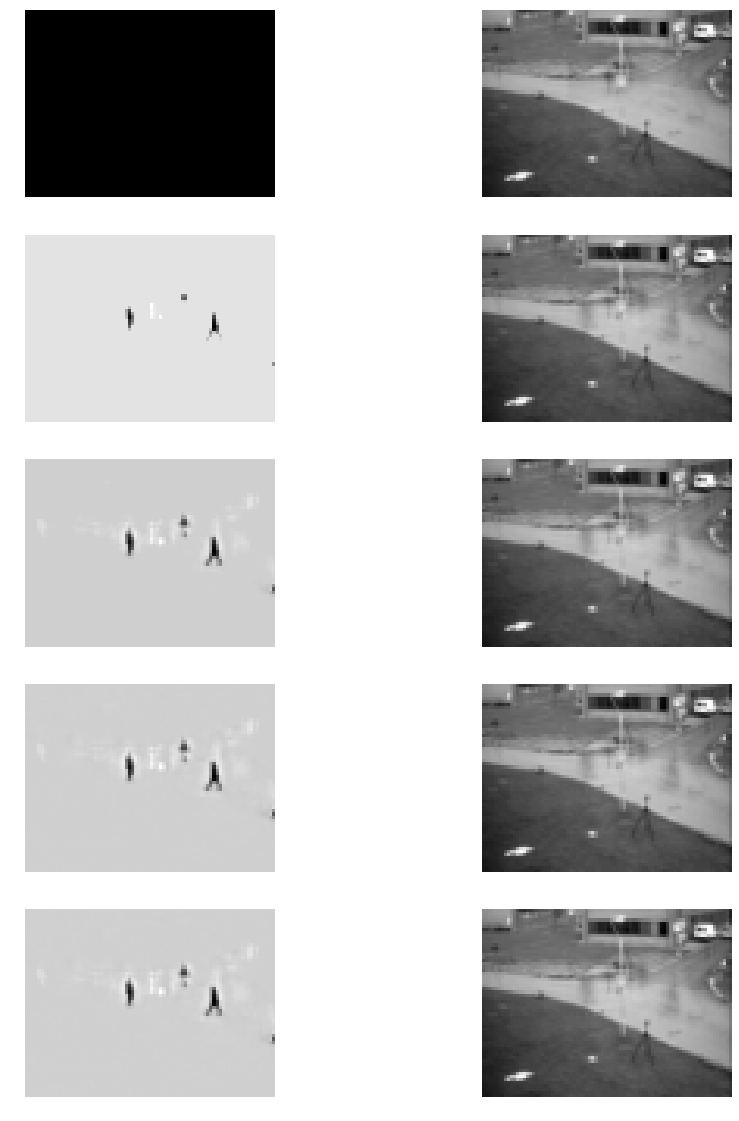

In [61]:
plots(examples, dims, rows = 5)

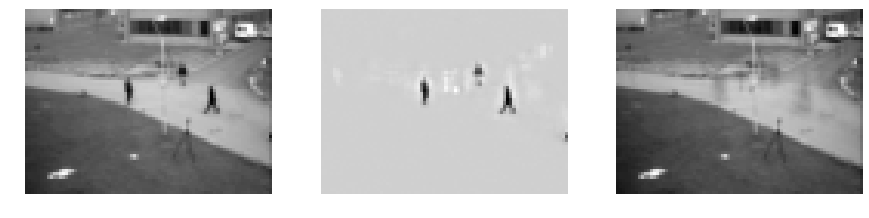

In [62]:
f = plt_images(M, S, L, [140], dims)

In [0]:
np.save("high_res_L.npy", L)
np.save("high_res_S.npy", S)

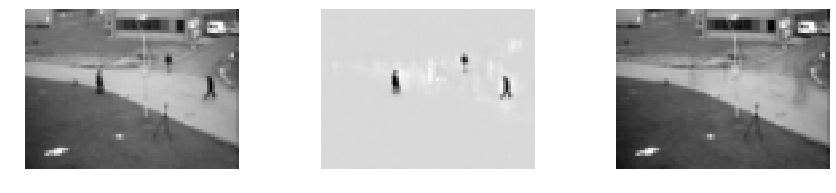

In [65]:
f = plt_images(M, S, L, [0, 100, 1000], dims)